## Loading Advertising Data

In [2]:
import org.apache.spark.sql.types._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.streaming._

val rawData = spark
    .readStream
    .format("kafka")
    .option("kafka.bootstrap.servers", "localhost:9092")
    .option("subscribe", "advertising")
    .option("startingOffsets", "earliest") 
    .load()


import org.apache.spark.sql.types._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.streaming._
rawData: org.apache.spark.sql.DataFrame = [key: binary, value: binary ... 5 more fields]


In [3]:
rawData.printSchema

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [4]:
println("""
* 'Daily Time Spent on Site': consumer time on site in minutes
* 'Age': cutomer age in years
* 'Area Income': Avg. Income of geographical area of consumer
* 'Daily Internet Usage': Avg. minutes a day consumer is on the internet
* 'Ad Topic Line': Headline of the advertisement
* 'City': City of consumer
* 'Male': Whether or not consumer was male
* 'Country': Country of consumer
* 'Timestamp': Time at which consumer clicked on Ad or closed window
* 'Clicked on Ad': 0 or 1 indicated clicking on Ad
""")

val schema = StructType(
  Array(
    StructField("daily_time_spend", DoubleType, true),
    StructField("age", IntegerType, true),
    StructField("area_income", DoubleType, true),
    StructField("daily_internet_usage", DoubleType, true),
    StructField("ad_topic_line", StringType, true),
    StructField("city", StringType, true),
    StructField("male", DoubleType, true),
    StructField("country", StringType, true), 
    StructField("timestamp", TimestampType, true),
    StructField("clicked", DoubleType, true) 
  )
)



* 'Daily Time Spent on Site': consumer time on site in minutes
* 'Age': cutomer age in years
* 'Area Income': Avg. Income of geographical area of consumer
* 'Daily Internet Usage': Avg. minutes a day consumer is on the internet
* 'Ad Topic Line': Headline of the advertisement
* 'City': City of consumer
* 'Male': Whether or not consumer was male
* 'Country': Country of consumer
* 'Timestamp': Time at which consumer clicked on Ad or closed window
* 'Clicked on Ad': 0 or 1 indicated clicking on Ad



schema: org.apache.spark.sql.types.StructType = StructType(StructField(daily_time_spend,DoubleType,true), StructField(age,IntegerType,true), StructField(area_income,DoubleType,true), StructField(daily_internet_usage,DoubleType,true), StructField(ad_topic_line,StringType,true), StructField(city,StringType,true), StructField(male,DoubleType,true), StructField(country,StringType,true), StructField(timestamp,TimestampType,true), StructField(clicked,DoubleType,true))


In [5]:
val data = rawData.selectExpr("CAST(value AS string)")
    .select(from_json($"value", schema).alias("json")).selectExpr("json.*")

data.writeStream
.trigger(Trigger.Once())
.format("memory")
.queryName("advertising")
.start()
.awaitTermination


data: org.apache.spark.sql.DataFrame = [daily_time_spend: double, age: int ... 8 more fields]


In [6]:
spark.catalog.listTables.show
val advertising = spark.table("advertising")
advertising.printSchema

+-----------+--------+-----------+---------+-----------+
|       name|database|description|tableType|isTemporary|
+-----------+--------+-----------+---------+-----------+
|advertising|    null|       null|TEMPORARY|       true|
+-----------+--------+-----------+---------+-----------+

root
 |-- daily_time_spend: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- area_income: double (nullable = true)
 |-- daily_internet_usage: double (nullable = true)
 |-- ad_topic_line: string (nullable = true)
 |-- city: string (nullable = true)
 |-- male: double (nullable = true)
 |-- country: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- clicked: double (nullable = true)



advertising: org.apache.spark.sql.DataFrame = [daily_time_spend: double, age: int ... 8 more fields]


## Exploratory Analysis

In [7]:
advertising.select("daily_time_spend","age","area_income","daily_internet_usage").summary().show()

+-------+------------------+----------------+------------------+--------------------+
|summary|  daily_time_spend|             age|       area_income|daily_internet_usage|
+-------+------------------+----------------+------------------+--------------------+
|  count|              1000|            1000|              1000|                1000|
|   mean| 65.00019999999999|          36.009|       55000.00008|            180.0001|
| stddev|15.853614567500209|8.78556231012592|13414.634022282358|    43.9023393019801|
|    min|              32.6|              19|           13996.5|              104.78|
|    25%|              51.3|              29|          46974.15|              138.71|
|    50%|             68.18|              35|          57009.76|              182.84|
|    75%|             78.54|              42|          65461.92|              218.79|
|    max|             91.43|              61|           79484.8|              269.96|
+-------+------------------+----------------+---------

In [8]:
advertising.select("ad_topic_line").show(5, false)

+-------------------------------------+
|ad_topic_line                        |
+-------------------------------------+
|Cloned 5thgeneration orchestration   |
|Monitored national standardization   |
|Organic bottom-line service-desk     |
|Triple-buffered reciprocal time-frame|
|Robust logistical utilization        |
+-------------------------------------+
only showing top 5 rows



In [9]:
println("==== male ====")
advertising.groupBy("male").count()
    .withColumn("cum_percent", col("count") * 100 /  sum("count").over())
    .show

println("==== clicked ====")
advertising.groupBy("clicked").count()
    .withColumn("cum_percent", col("count") * 100 /  sum("count").over())
    .show

==== male ====
+----+-----+-----------+
|male|count|cum_percent|
+----+-----+-----------+
| 0.0|  519|       51.9|
| 1.0|  481|       48.1|
+----+-----+-----------+

==== clicked ====
+-------+-----+-----------+
|clicked|count|cum_percent|
+-------+-----+-----------+
|    0.0|  500|       50.0|
|    1.0|  500|       50.0|
+-------+-----+-----------+



## Visualizing Data

In [10]:
advertising.createOrReplaceTempView("advertising")
spark.catalog.listTables.show

+-----------+--------+-----------+---------+-----------+
|       name|database|description|tableType|isTemporary|
+-----------+--------+-----------+---------+-----------+
|advertising|    null|       null|TEMPORARY|       true|
+-----------+--------+-----------+---------+-----------+



In [11]:
%%python
import databricks.koalas as ks
import tempfile
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image

ks.set_option("plotting.max_rows", 1000000)
advertising = spark.sql("select * from advertising").to_koalas()
print(advertising.head(5))

   daily_time_spend  age  area_income  daily_internet_usage                          ad_topic_line            city  male     country           timestamp  clicked
0             68.95   35     61833.90                256.09     Cloned 5thgeneration orchestration     Wrightburgh   0.0     Tunisia 2016-03-27 00:53:11      0.0
1             80.23   31     68441.85                193.77     Monitored national standardization       West Jodi   1.0       Nauru 2016-04-04 01:39:02      0.0
2             69.47   26     59785.94                236.50       Organic bottom-line service-desk        Davidton   0.0  San Marino 2016-03-13 20:35:42      0.0
3             74.15   29     54806.18                245.89  Triple-buffered reciprocal time-frame  West Terrifurt   1.0       Italy 2016-01-10 02:31:19      0.0
4             68.37   35     73889.99                225.58          Robust logistical utilization    South Manuel   0.0     Iceland 2016-06-03 03:36:18      0.0


### Comparing daily_internet_usage and daily_time_spend 

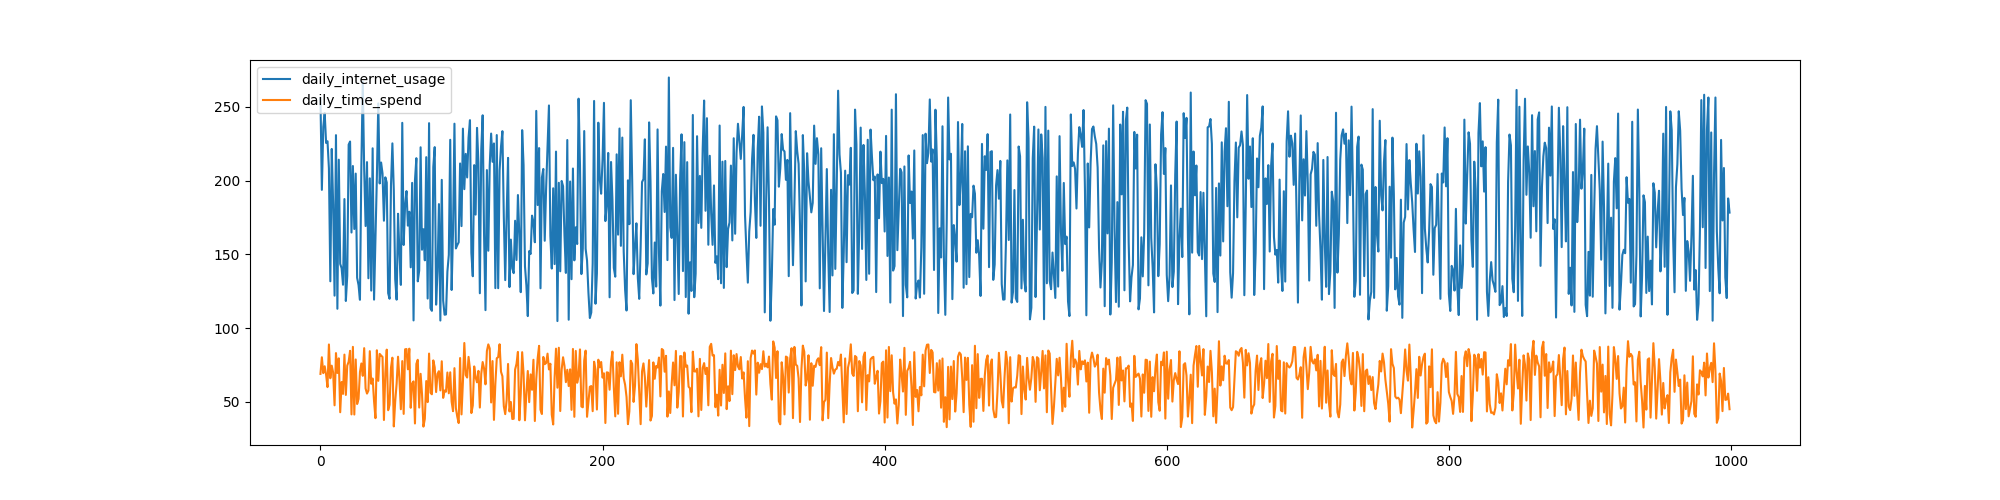

In [12]:
%%python

plt.rcParams['figure.figsize'] = [20, 5]

advertising.plot(y=["daily_internet_usage","daily_time_spend"])

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

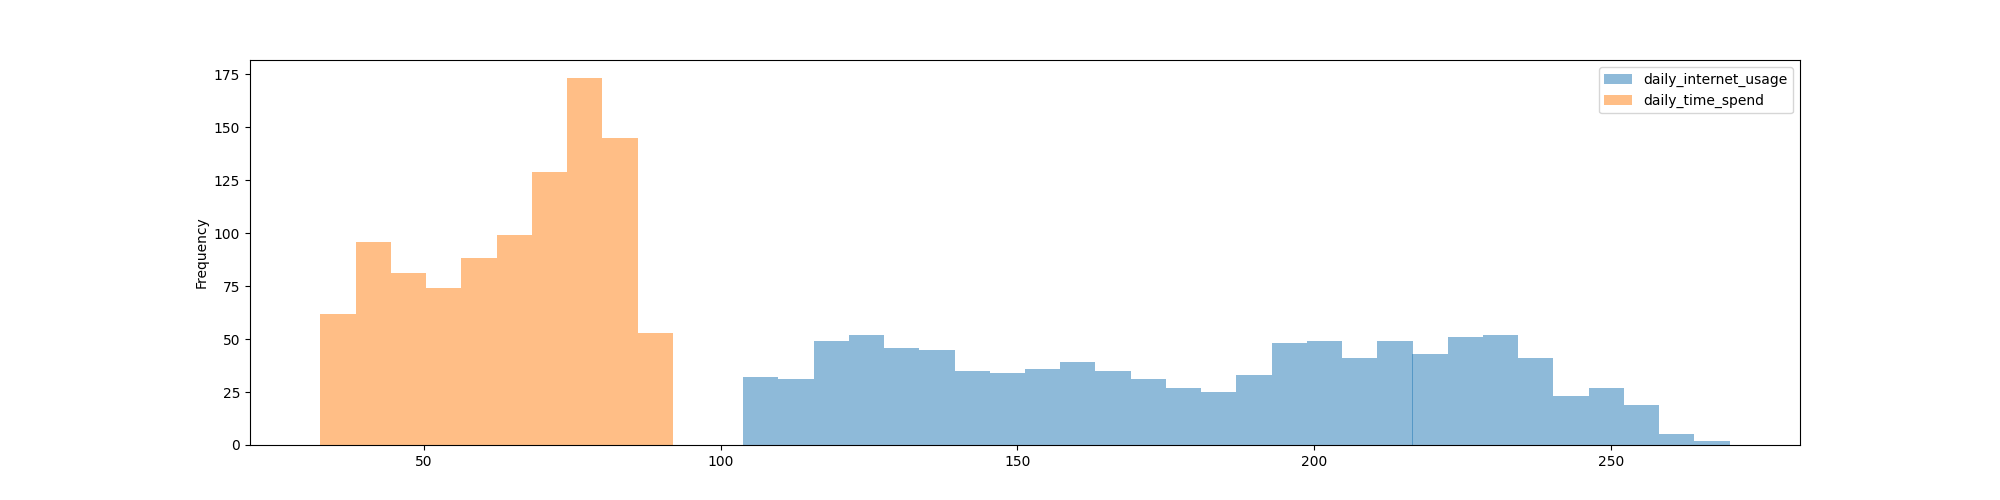

In [13]:
%%python

advertising[['daily_internet_usage','daily_time_spend']].plot.hist(bins=40, alpha=0.5)

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

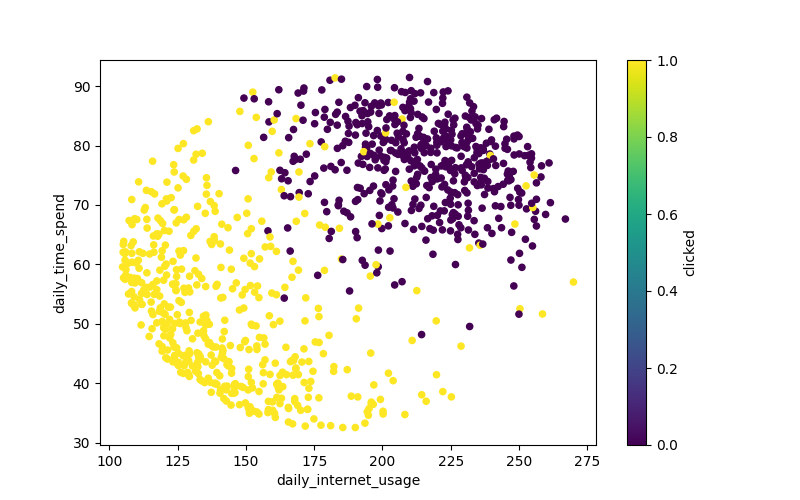

In [14]:
%%python
plt.rcParams['figure.figsize'] = [8, 5]

advertising.plot.scatter(x='daily_internet_usage',y='daily_time_spend',c='clicked',colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

### Comparing age, area_income and clicked

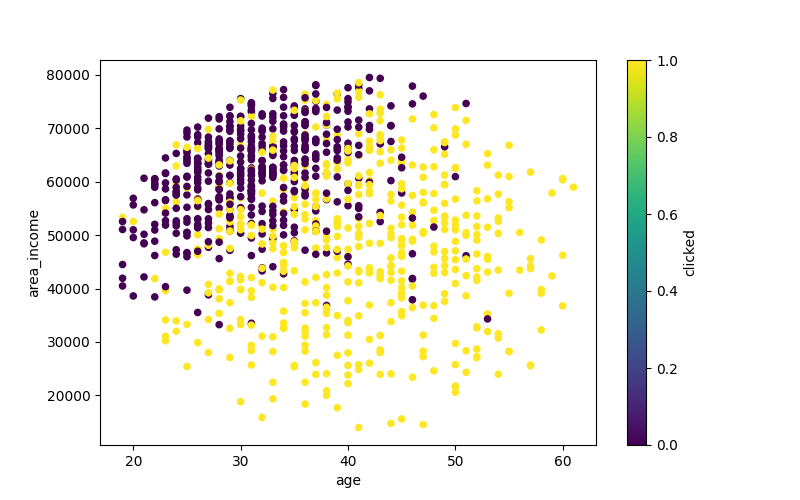

In [15]:
%%python

plt.rcParams['figure.figsize'] = [8, 5]

advertising.plot.scatter(x='age',y='area_income',c='clicked',colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

### Comparing male, age and clicked

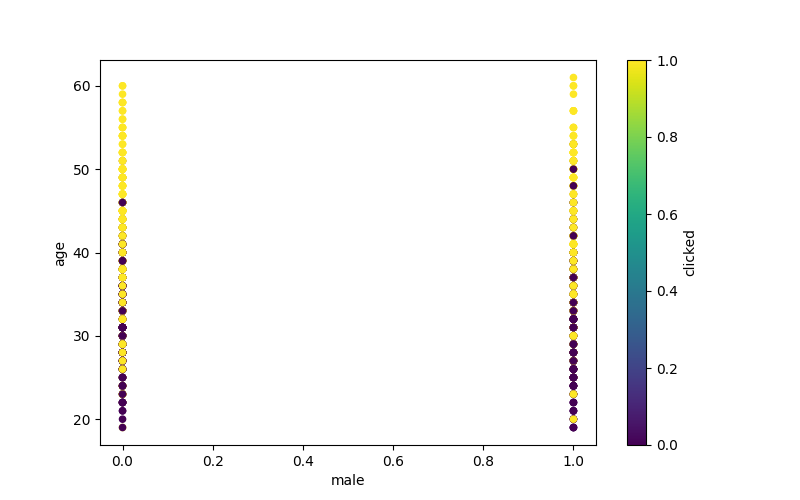

In [16]:
%%python

plt.rcParams['figure.figsize'] = [8, 5]

advertising.plot.scatter(x='male',y='age',c='clicked',colormap="viridis")

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

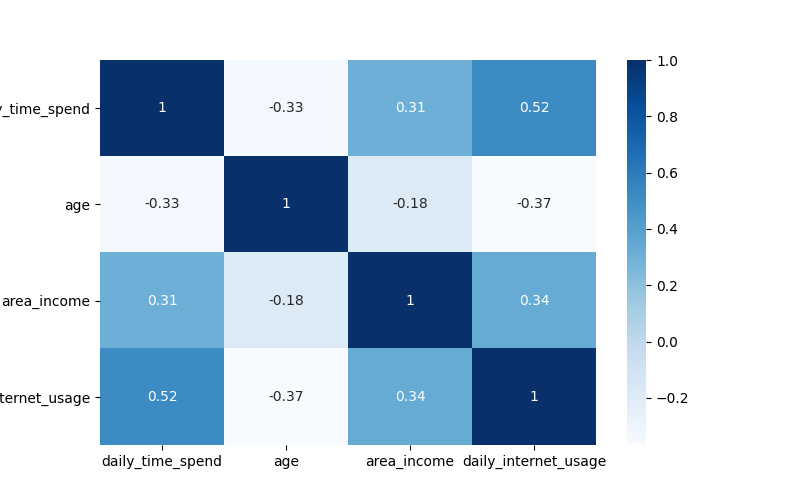

In [17]:
%%python

plt.clf()

columns = ["daily_time_spend","age","area_income","daily_internet_usage"]

corr_values = advertising[columns].corr().to_numpy()

sns.heatmap(corr_values, cmap='Blues', annot = True, square = False,
            xticklabels=columns,yticklabels=columns)

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Building the ML Model

In [18]:
import org.apache.spark.ml.classification.LogisticRegression
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.evaluation.BinaryClassificationEvaluator
import org.apache.spark.ml.Pipeline

val Array(train, test) = advertising
    .randomSplit(Array(0.7, 0.3))

println("==== train ====")
train.show(5)
println("==== test ====")
test.show(5)

==== train ====
+----------------+---+-----------+--------------------+--------------------+------------------+----+-------------+-------------------+-------+
|daily_time_spend|age|area_income|daily_internet_usage|       ad_topic_line|              city|male|      country|          timestamp|clicked|
+----------------+---+-----------+--------------------+--------------------+------------------+----+-------------+-------------------+-------+
|           33.21| 43|   42650.32|              167.07|Polarized clear-t...|        Wilcoxport| 1.0|       Turkey|2016-05-10 17:39:06|    1.0|
|           33.33| 45|   53350.11|              193.58|Pre-emptive value...|East Samanthashire| 1.0|Guinea-Bissau|2016-01-17 09:31:36|    1.0|
|           35.61| 46|   51868.85|              158.22|Up-sized secondar...|     North Michael| 0.0|        Egypt|2016-03-28 08:46:26|    1.0|
|           37.68| 52|   53575.48|              172.83|Organic leadinged...|Lake Cassandraport| 1.0| Turkmenistan|2016-02-17 1

import org.apache.spark.ml.classification.LogisticRegression
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.evaluation.BinaryClassificationEvaluator
import org.apache.spark.ml.Pipeline
train: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [daily_time_spend: double, age: int ... 8 more fields]
test: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [daily_time_spend: double, age: int ... 8 more fields]


In [64]:
// -------------------
// defining pipeline
// -------------------

// VectorAssembler Transformer 
val va = new VectorAssembler()
 .setInputCols(Array("daily_internet_usage","daily_time_spend","area_income","age"))
 .setOutputCol("features")

// LogisticRegression Estimator
val lr = new LogisticRegression()
    .setLabelCol("clicked")
    .setFamily("binomial")
    .setMaxIter(100)
    .setElasticNetParam(0.8)
    .setRegParam(0.3)


va: org.apache.spark.ml.feature.VectorAssembler = VectorAssembler: uid=vecAssembler_4b058f62f467, handleInvalid=error, numInputCols=4
lr: org.apache.spark.ml.classification.LogisticRegression = logreg_fa7b44044a84


In [65]:
// -------------------
// defining stages
// -------------------

val stages = Array(va, lr)

stages: Array[org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.PipelineStage with org.apache.spark.ml.util.DefaultParamsWritable}}] = Array(VectorAssembler: uid=vecAssembler_4b058f62f467, handleInvalid=error, numInputCols=4, logreg_fa7b44044a84)


In [66]:
// building pipeline
val pipeline = new Pipeline().setStages(stages)

pipeline: org.apache.spark.ml.Pipeline = pipeline_05f6a597b3d4


In [67]:
val lrModel = pipeline.fit(train)

lrModel: org.apache.spark.ml.PipelineModel = pipeline_05f6a597b3d4


In [68]:
import org.apache.spark.ml.classification.LogisticRegressionModel
lrModel.stages(1).asInstanceOf[LogisticRegressionModel].coefficients

import org.apache.spark.ml.classification.LogisticRegressionModel
res28: org.apache.spark.ml.linalg.Vector = [-0.00913888639287505,-0.016698543068194214,0.0,0.0]


In [69]:
val prediction = lrModel.transform(test)

prediction: org.apache.spark.sql.DataFrame = [daily_time_spend: double, age: int ... 12 more fields]


In [70]:
prediction.printSchema

root
 |-- daily_time_spend: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- area_income: double (nullable = true)
 |-- daily_internet_usage: double (nullable = true)
 |-- ad_topic_line: string (nullable = true)
 |-- city: string (nullable = true)
 |-- male: double (nullable = true)
 |-- country: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- clicked: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [71]:
// rawPrediction: output of the logit function
prediction.select("daily_internet_usage","daily_time_spend","area_income","age","clicked","prediction","rawPrediction","probability").show(false)

+--------------------+----------------+-----------+---+-------+----------+------------------------------------------+----------------------------------------+
|daily_internet_usage|daily_time_spend|area_income|age|clicked|prediction|rawPrediction                             |probability                             |
+--------------------+----------------+-----------+---+-------+----------+------------------------------------------+----------------------------------------+
|200.22              |35.33           |51510.18   |32 |1.0    |1.0       |[-0.3038908916182681,0.3038908916182681]  |[0.42460659901346554,0.5753934009865345]|
|162.08              |38.93           |27508.41   |39 |1.0    |1.0       |[-0.5923332635970229,0.5923332635970229]  |[0.3560996745564136,0.6439003254435863] |
|154.02              |45.72           |22473.08   |36 |1.0    |1.0       |[-0.5526095804905573,0.5526095804905573]  |[0.36525917856666246,0.6347408214333375]|
|231.94              |49.58           |56791.7

In [72]:
val evaluator = new BinaryClassificationEvaluator()
    .setLabelCol("clicked")
    .setRawPredictionCol("prediction")
    .setMetricName("areaUnderROC")

val accuracy = evaluator.evaluate(prediction)
println(accuracy)

0.9633959544082533


evaluator: org.apache.spark.ml.evaluation.BinaryClassificationEvaluator = BinaryClassificationEvaluator: uid=binEval_e4669e7108c5, metricName=areaUnderROC, numBins=1000
accuracy: Double = 0.9633959544082533
